<a href="https://colab.research.google.com/github/infocornouaille/premiere_nsi/blob/main/Adrien_Briec_2022_2023_1nsi_projet_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mini-Projet: Meteorite Landings

In [ ]:
!pip install geopandas
!pip install folium
!pip install matplotlib
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importation des modules

In [ ]:
# Sources = geopandas.org
import pandas as pd
import geopandas as gpd  # utilisation de geopandas pour la carte
from shapely.geometry import Polygon, LineString, Point
import folium, matplotlib, mapclassify
import numpy as np

## Création de la carte

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Création du fichier des coordonnées

In [ ]:
df = pd.read_csv("https://data.nasa.gov/resource/gh4g-9sfh.csv")
#coord = df.loc["geolocation"]  # Erreur à cette ligne
coord = df.loc[:, ["name","mass","year", "geolocation"]]  # Correction de cette ligne

In [ ]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,geolocation
0,Aachen,1,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,"(-33.16667, -64.95)"


In [ ]:
coord.head()

,name,mass,year,geolocation
0,Aachen,21.0,1880-01-01T00:00:00.000,"(50.775, 6.08333)"
1,Aarhus,720.0,1951-01-01T00:00:00.000,"(56.18333, 10.23333)"
2,Abee,107000.0,1952-01-01T00:00:00.000,"(54.21667, -113.0)"
3,Acapulco,1914.0,1976-01-01T00:00:00.000,"(16.88333, -99.9)"
4,Achiras,780.0,1902-01-01T00:00:00.000,"(-33.16667, -64.95)"


##Fonction formattant les coordonnées

Commentaires et modifications du code:

- le type de `coord` est `str` dans le dataframe.
- On "enlève" les parentèses, on "split" par la virgule, ce qui nous donne deux "nombres" mais encore au format `str`
- on convertir en `float` puis on créé un objet `Point`


In [ ]:
def format_coord(coord):
  """Convertir un texte "(x,y)" en objet Point(x,y)
  In: un str sous le format "(x,y)" avec x et y des flottants ou bien
  un tuple (x,y)
  Out: un objet Point(x,y)
  """
  if type(coord) == str:
    coord = coord.replace("(","").replace(")","")
    x,y = coord.split(",")
    x,y = float(x),float(y)
    return(Point(y,x))
  elif isinstance(Point(5.2, 52.1),Point): # si l'objet est déjà un Point
    return coord
 
  elif type(coord) == tuple: # si c'est un tuple (x,y)
    x, y = coord # unpack
    return Point(y,x)
    
  return coord # dans tous autres cas on retourne coord (redondance avec le 2ième elif ici...)

Fonction prenant seulement l'année

In [ ]:
def format_year(year):
  for i in range(len(year)):
    if year[i] == "-":
      return year[0:i-1]

## Formatage des coordonnées

Il faut ajouter une colonne `geometry` pour l'utilisation avec geopandas.
On enleve la colonne `geolocation`

In [ ]:
coord["geometry"] = coord["geolocation"].apply(format_coord)
coord = coord.drop("geolocation", 1)
coord.head()

<ipython-input-177-f047e535cc01>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  coord = coord.drop("geolocation", 1)


,name,mass,year,geometry
0,Aachen,21.0,1880-01-01T00:00:00.000,POINT (6.08333 50.775)
1,Aarhus,720.0,1951-01-01T00:00:00.000,POINT (10.23333 56.18333)
2,Abee,107000.0,1952-01-01T00:00:00.000,POINT (-113 54.21667)
3,Acapulco,1914.0,1976-01-01T00:00:00.000,POINT (-99.9 16.88333)
4,Achiras,780.0,1902-01-01T00:00:00.000,POINT (-64.95 -33.16667)


On enleve chaque ligne ou il n'y a pas de données, on formatte l'année et on ajoute l'unité a la masse.

In [ ]:
coord = coord.dropna(axis=0, how="any")
coord["year"] = coord["year"].apply(format_year)
coord.rename(columns={'mass': 'mass (g)'})

,name,mass (g),year,geometry
0,Aachen,21.0,188,POINT (6.08333 50.775)
1,Aarhus,720.0,195,POINT (10.23333 56.18333)
2,Abee,107000.0,195,POINT (-113 54.21667)
3,Acapulco,1914.0,197,POINT (-99.9 16.88333)
4,Achiras,780.0,190,POINT (-64.95 -33.16667)
...,...,...,...,...
995,Tirupati,230.0,193,POINT (79.41667 13.63333)
996,Tissint,7000.0,201,POINT (-7.61123 29.48195)
997,Tjabe,20000.0,186,POINT (111.53333 -7.08333)
998,Tjerebon,16500.0,192,POINT (106.58333 -6.66667)


## Création d'un dataframe geopanda

https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html

In [ ]:
coord1 = gpd.GeoDataFrame(coord,crs="EPSG:4326")

Pour le `crs="EPSG:4326"`il faudra peut-être regarder de plus près la documentation

In [ ]:
coord1["geometry"]

0         POINT (6.08333 50.77500)
1        POINT (10.23333 56.18333)
2      POINT (-113.00000 54.21667)
3       POINT (-99.90000 16.88333)
4      POINT (-64.95000 -33.16667)
                  ...             
995      POINT (79.41667 13.63333)
996      POINT (-7.61123 29.48195)
997     POINT (111.53333 -7.08333)
998     POINT (106.58333 -6.66667)
999      POINT (34.76667 47.85000)
Name: geometry, Length: 959, dtype: geometry

<AxesSubplot:>

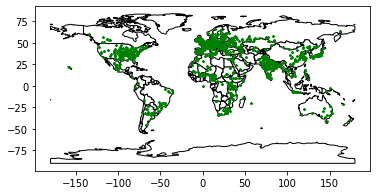

In [ ]:
base = world.plot(color='white', edgecolor='black')
coord1.plot(ax=base, marker='*', color='green', markersize=5)


#coord.plot(marker='*', color='green', markersize=5)

# Création de la carte interractive

In [ ]:
coord1.explore(
    color="red",
    marker_kwds=dict(radius=8, fill=True),
)

### Une fois le code executé sur une carte nous pouvons observez une répartition non-égal des crashs de météroites, ce qui a première vue est normale. Mais aucune météroite n'as été repertorié dans l'océan, au pole sud/nord, dans les pays moins développé, des endroits difficile d'accès en général et les pays dictactoriaux.

Nous voulions faire que lorsque nous clickons sur un point de météroite cela nous dirige vers un site où on l'on pourrait retrouvé une description plus détaillé. Mais nous n'avons pas trouvé comment le faire avec les bibliothèques pandas/geopandas et toutes les météroites n'ont pas une description détaillé.